In [2]:
%%capture
!pip install datasets

# Synthetic Tabular data Generator

This notebook contains code adapted from [Tabula](https://github.com/zhao-zilong/Tabula/tree/main), a tabular data synthesizer based on the large language model structures.

Some adjustments were made to better suit the specific data requirements and objectives.

Code Modifications:
- _convert_text_to_tabular_data function: Adjusted to allow multiple words as values in each column.
- Handling Missing Values: Originally, the code discarded generated rows with missing values, but for our project, retaining NULL values in certain fields was necessary to mimic the distribution of original data correctly. So, the code adjusted to allow missing values in generated data.
- Sample Generation Issue: The original code did not append samples when generating more than 100, causing output limitations. This issue was resolved to ensure samples are appended correctly in each iteration.

Dataset preprocessing:
- Column Naming: The code assumed single-word column names, conflicting with our dataset’s multi-word headers. Column names were adapted by replacing spaces with underscores.
- Comma Handling: As the model uses commas to separate between generated columns, data containing commas (e.g., in "TAG" or "Job Description" fields) posed issues. To address this, commas in dataset were replaced with semicolons.
- Character Limit: The model encounters errors with entries over 1024 characters which is the maximum token length. To avoid this, records exceeding this character limit were removed from the input to the model.



In [3]:
import os
import json
import random
import logging
import warnings
import numpy as np
import pandas as pd
import typing as tp
from tqdm import tqdm
from datasets import Dataset
import matplotlib.pyplot as plt
from dataclasses import dataclass
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributed as dist
from torch.utils.data import DataLoader
from scipy.spatial.distance import jensenshannon
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from scipy.stats import entropy
from transformers import (Trainer,
                          DataCollatorWithPadding,
                          AutoTokenizer,
                          AutoModelForCausalLM,
                          TrainingArguments,
                          AutoConfig)

os.environ["WANDB_DISABLED"] = "true"

## Utils
This section contains utility functions and helper tools for Tabula synthesizer that streamline and support the main processes in the notebook. 

In [ ]:

def _array_to_dataframe(data: tp.Union[pd.DataFrame, np.ndarray], columns=None) -> pd.DataFrame:
    """ Converts a Numpy Array to a Pandas DataFrame

    Args:
        data: Pandas DataFrame or Numpy NDArray
        columns: If data is a Numpy Array, columns needs to be a list of all column names

    Returns:
        Pandas DataFrame with the given data
    """
    if isinstance(data, pd.DataFrame):
        return data

    assert isinstance(data, np.ndarray), "Input needs to be a Pandas DataFrame or a Numpy NDArray"
    assert columns, "To convert the data into a Pandas DataFrame, a list of column names has to be given!"
    assert len(columns) == len(data[0]), \
        "%d column names are given, but array has %d columns!" % (len(columns), len(data[0]))

    return pd.DataFrame(data=data, columns=columns)


def _get_column_distribution(df: pd.DataFrame, col: str) -> tp.Union[list, dict]:
    """ Returns the distribution of a given column. If continuous, returns a list of all values.
        If categorical, returns a dictionary in form {"A": 0.6, "B": 0.4}

    Args:
        df: pandas DataFrame
        col: name of the column

    Returns:
        Distribution of the column
    """
    if df[col].dtype == "float":
        col_dist = df[col].to_list()
    else:
        col_dist = df[col].value_counts(1).to_dict()
    return col_dist


def _convert_tokens_to_text(tokens: tp.List[torch.Tensor], tokenizer: AutoTokenizer) -> tp.List[str]:
    """ Decodes the tokens back to strings

    Args:
        tokens: List of tokens to decode
        tokenizer: Tokenizer used for decoding

    Returns:
        List of decoded strings
    """
    # Convert tokens to text
    text_data = [tokenizer.decode(t) for t in tokens]

    # Clean text
    text_data = [d.replace("<|endoftext|>", "") for d in text_data]
    text_data = [d.replace("\n", " ") for d in text_data]
    text_data = [d.replace("\r", "") for d in text_data]

    return text_data


def _convert_text_to_tabular_data(text: tp.List[str], df_gen: pd.DataFrame) -> pd.DataFrame:
    """ Converts the sentences back to tabular data

    Args:
        text: List of the tabular data in text form
        df_gen: Pandas DataFrame where the tabular data is appended

    Returns:
        Pandas DataFrame with the tabular data from the text appended
    """
    columns = df_gen.columns.to_list()
    columns = [column.strip() for column in columns]
    result_list = []
    k = 0
    # Convert text to tabular data
    for t in text:
        features = t.split(",")
        td = dict.fromkeys(columns)

        # Transform all features back to tabular data
        for f in features:
            values = f.split(" ")
            # values = f.strip().split(" ")
            if len(values[0]) == 0:
                k = 1
            try:
                if values[k] in columns and not td[values[k]]:
                    try:
                        # td[values[0]] = [values[1]]
                        td[values[k]] = [' '.join(map(str, values[k+1:]))]
                    except IndexError:
                        # print("An Index Error occurred - if this happends a lot, consider fine-tuning your model further.")
                        pass
            except Exception:
                # print('error------', Exception)
                pass
        result_list.append(pd.DataFrame(td, index=[0]))
        # df_gen = pd.concat([df_gen, pd.DataFrame(td)], ignore_index=True, axis=0)

    generated_df = pd.concat(result_list, ignore_index=True, axis=0)
    # df_gen = pd.concat([df_gen, generated_df], ignore_index=True, axis=0)
    # print('generated_df::::::::', td)
    return generated_df

Tabula Trainer

In [ ]:

def _seed_worker(_):
    """
    Helper function to set worker seed during Dataloader initialization.
    """
    worker_seed = torch.initial_seed() % 2**32
    random.seed(worker_seed)
    np.random.seed(worker_seed)
    torch.manual_seed(worker_seed)
    torch.cuda.manual_seed_all(worker_seed)


class TabulaTrainer(Trainer):
    """ Tabula Trainer

    Overwrites the get_train_dataloader methode of the HuggingFace Trainer to not remove the "unused" columns -
    they are needed later!
    """
    def get_train_dataloader(self) -> DataLoader:
        if self.train_dataset is None:
            raise ValueError("Trainer: training requires a train_dataset.")

        data_collator = self.data_collator
        train_dataset = self.train_dataset  # self._remove_unused_columns(self.train_dataset, description="training")
        train_sampler = self._get_train_sampler()

        return DataLoader(
            train_dataset,
            batch_size=self._train_batch_size,
            sampler=train_sampler,
            collate_fn=data_collator,
            drop_last=self.args.dataloader_drop_last,
            num_workers=self.args.dataloader_num_workers,
            pin_memory=self.args.dataloader_pin_memory,
            worker_init_fn=_seed_worker,
        )

Tabula start

In [ ]:

def _pad(x, length: int, pad_value=50256):
    """
    Prepend the pad value until the array reaches the specific length
    """
    return [pad_value] * (length - len(x)) + x


#
def _pad_tokens(tokens):
    """
    Checks that all tensors in the list have the same length, pads them if necessary to the max length

    Args:
        tokens: List of Tensors

    Returns:
        List of Tensors, where each Tensor has the same length
    """
    max_length = len(max(tokens, key=len))
    tokens = [_pad(t, max_length) for t in tokens]
    return tokens


class TabulaStart:
    """ Abstract super class Tabula Start

    Tabula Start creates tokens to start the generation process.

    Attributes:
        tokenizer (AutoTokenizer): Tokenizer, automatically downloaded from llm-checkpoint
    """
    def __init__(self, tokenizer):
        """
        Initializes the super class.

        Args:
            tokenizer: Tokenizer from the HuggingFace library
        """
        self.tokenizer = tokenizer

    def get_start_tokens(self, n_samples: int) -> tp.List[tp.List[int]]:
        """ Get Start Tokens

        Creates starting points for the generation process

        Args:
            n_samples: Number of start prompts to create

        Returns:
            List of n_sample lists with tokens
        """
        raise NotImplementedError("This has to be overwritten but the subclasses")


class CategoricalStart(TabulaStart):
    """ Categorical Starting Feature

    A categorical column with its categories is used as starting point.

    Attributes:
        start_col (str): Name of the categorical column
        population (list[str]): Possible values the column can take
        weights (list[float]): Probabilities for the individual categories

    """
    def __init__(self, tokenizer, start_col: str, start_col_dist: dict):
        """ Initializes the Categorical Start

        Args:
            tokenizer: Tokenizer from the HuggingFace library
            start_col: Name of the categorical column
            start_col_dist: Distribution of the categorical column (dict of form {"Cat A": 0.8, "Cat B": 0.2})
        """
        super().__init__(tokenizer)

        assert isinstance(start_col, str), ""
        assert isinstance(start_col_dist, dict), ""

        self.start_col = start_col
        self.population = list(start_col_dist.keys())
        self.weights = list(start_col_dist.values())

    def get_start_tokens(self, n_samples):
        start_words = random.choices(self.population, self.weights, k=n_samples)
        start_text = [self.start_col + " " + str(s) + "," for s in start_words]
        start_tokens = _pad_tokens(self.tokenizer(start_text)["input_ids"])
        return start_tokens


class ContinuousStart(TabulaStart):
    """ Continuous Starting Feature

    A continuous column with some noise is used as starting point.

    Attributes:
        start_col (str): Name of the continuous column
        start_col_dist (list[float]): The continuous column from the train data set
        noise (float): Size of noise that is added to each value
        decimal_places (int): Number of decimal places the continuous values have
    """
    def __init__(self, tokenizer, start_col: str, start_col_dist: tp.List[float],
                 noise: float = .01, decimal_places: int = 5):
        """ Initializes the Continuous Start

        Args:
            tokenizer: Tokenizer from the HuggingFace library
            start_col: Name of the continuous column
            start_col_dist: The continuous column from the train data set
            noise: Size of noise that is added to each value
            decimal_places: Number of decimal places the continuous values have
        """
        super().__init__(tokenizer)

        assert isinstance(start_col, str), ""
        assert isinstance(start_col_dist, list), ""

        self.start_col = start_col
        self.start_col_dist = start_col_dist
        self.noise = noise
        self.decimal_places = decimal_places

    def get_start_tokens(self, n_samples):
        start_words = random.choices(self.start_col_dist, k=n_samples)
        start_text = [self.start_col + " " + format(s, f".{self.decimal_places}f") + "," for s in start_words]
        start_tokens = _pad_tokens(self.tokenizer(start_text)["input_ids"])
        return start_tokens


class RandomStart(TabulaStart):
    """ Random Starting Features

    Random column names are used as start point. Can be used if no distribution of any column is known.

    Attributes:
        all_columns (List[str]): Names of all columns
    """
    def __init__(self, tokenizer, all_columns: tp.List[str]):
        """ Initializes the Random Start

        Args:
            tokenizer: Tokenizer from the HuggingFace library
            all_columns: Names of all columns
        """
        super().__init__(tokenizer)
        self.all_columns = all_columns

    def get_start_tokens(self, n_samples):
        start_words = random.choices(self.all_columns, k=n_samples)
        start_text = [s + " " for s in start_words]
        start_tokens = _pad_tokens(self.tokenizer(start_text)["input_ids"])
        return start_tokens

Tabula dataset

In [ ]:

class TabulaDataset(Dataset):
    """ Tabula Dataset

    The TabulaDataset overwrites the _getitem function of the HuggingFace Dataset Class to include the permutation step.

    Attributes:
        tokenizer (AutoTokenizer): Tokenizer from HuggingFace
    """
    def set_tokenizer(self, tokenizer):
        """ Set the Tokenizer

        Args:
            tokenizer: Tokenizer from HuggingFace
        """
        self.tokenizer = tokenizer

    def _getitem(self, key: tp.Union[int, slice, str], decoded: bool = True, **kwargs) -> tp.Union[tp.Dict, tp.List]:
        """ Get Item from Tabular Data

        Get one instance of the tabular data, permuted, converted to text and tokenized.
        """
        # If int, what else?
        row = self._data.fast_slice(key, 1)

        shuffle_idx = list(range(row.num_columns))
        random.shuffle(shuffle_idx)

        shuffled_text = ", ".join(
            ["%s %s" % (row.column_names[i], str(row.columns[i].to_pylist()[0]).strip()) for i in shuffle_idx]
        )

        tokenized_text = self.tokenizer(shuffled_text)
        return tokenized_text

    def __getitems__(self, keys: tp.Union[int, slice, str, list]):
        if isinstance(keys, list):
            return [self._getitem(key) for key in keys]
        else:
            return self._getitem(keys)

@dataclass
class TabulaDataCollator(DataCollatorWithPadding):
    """ Tabula Data Collator

    Overwrites the DataCollatorWithPadding to also pad the labels and not only the input_ids
    """
    def __call__(self, features: tp.List[tp.Dict[str, tp.Any]]):
        batch = self.tokenizer.pad(
            features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors=self.return_tensors,
        )
        batch["labels"] = batch["input_ids"].clone()
        # Use following print to observe encoded token sequence length
        # print("labels shape: ", batch["labels"].shape)
        return batch

## Tabula Model
This part handles the generation flow. It consists fine-tuning a large language model on tabular data, and to sample synthetic tabular data.

In [ ]:

class Tabula:
    """ Tabula Class

    The Tabula class handles the whole generation flow. It is used to fine-tune a large language model for tabular data,
    and to sample synthetic tabular data.

    Attributes:
        llm (str): HuggingFace checkpoint of a pretrained large language model, used a basis of our model
        tokenizer (AutoTokenizer): Tokenizer, automatically downloaded from llm-checkpoint
        model (AutoModelForCausalLM): Large language model, automatically downloaded from llm-checkpoint
        experiment_dir (str): Directory, where the training checkpoints will be saved
        epochs (int): Number of epochs to fine-tune the model
        batch_size (int): Batch size used for fine-tuning
        train_hyperparameters (dict): Additional hyperparameters added to the TrainingArguments used by the
         HuggingFaceLibrary, see here the full list of all possible values
         https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.TrainingArguments
        columns (list): List of all features/columns of the tabular dataset
        num_cols (list): List of all numerical features/columns of the tabular dataset
        conditional_col (str): Name of a feature/column on which the sampling can be conditioned
        conditional_col_dist (dict | list): Distribution of the feature/column specified by condtional_col
    """

    def __init__(self, llm: str, experiment_dir: str = "trainer_tabula", epochs: int = 100,
                 batch_size: int = 8, categorical_columns: list = [], **train_kwargs):
        """ Initializes Tabula.

        Args:
            llm: HuggingFace checkpoint of a pretrained large language model, used a basis of our model
            experiment_dir:  Directory, where the training checkpoints will be saved
            epochs: Number of epochs to fine-tune the model
            batch_size: Batch size used for fine-tuning
            train_kwargs: Additional hyperparameters added to the TrainingArguments used by the HuggingFaceLibrary,
             see here the full list of all possible values
             https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.TrainingArguments
        """

        # Load Model and Tokenizer from HuggingFace
        self.llm = llm
        self.tokenizer = AutoTokenizer.from_pretrained(self.llm)
        self.tokenizer.pad_token = self.tokenizer.eos_token
        self.config = AutoConfig.from_pretrained(self.llm)
        self.model = AutoModelForCausalLM.from_config(self.config)

        # Set the training hyperparameters
        self.experiment_dir = experiment_dir
        self.epochs = epochs
        self.batch_size = batch_size
        self.categorical_columns = categorical_columns
        self.train_hyperparameters = train_kwargs

        # Needed for the sampling process
        self.columns = None
        self.num_cols = None
        self.conditional_col = None
        self.conditional_col_dist = None


    def encode_categorical_column(self, data: pd.DataFrame):
        self.label_encoder_list = []
        for column_index, column in enumerate(data.columns):
            if column in self.categorical_columns:
                label_encoder = preprocessing.LabelEncoder()
                data[column] = data[column].astype(str)
                label_encoder.fit(data[column])
                current_label_encoder = dict()
                current_label_encoder['column'] = column
                current_label_encoder['label_encoder'] = label_encoder
                transformed_column = label_encoder.transform(data[column])
                data[column] = transformed_column
                self.label_encoder_list.append(current_label_encoder)
        return data


    def decode_categorical_column(self, data: pd.DataFrame):

        for i in range(len(self.label_encoder_list)):
            le = self.label_encoder_list[i]["label_encoder"]
            allowed_values = list(range(len(le.classes_)))


            # delete rows that should generate numeric value but generate other data type
            data[self.label_encoder_list[i]['column']] = pd.to_numeric(data[self.label_encoder_list[i]['column']], errors='coerce')
            data = data.dropna(subset=[self.label_encoder_list[i]['column']])
            # print('Decode data2:', data)

            # delete rows that generate category that is out of boundary
            data[self.label_encoder_list[i]['column']] = data[self.label_encoder_list[i]['column']].astype(float)
            data = data[data[self.label_encoder_list[i]['column']].isin(allowed_values)]
            # print('Decode data3:', data)

        for i in range(len(self.label_encoder_list)):
            le = self.label_encoder_list[i]["label_encoder"]
            data[self.label_encoder_list[i]["column"]] = data[self.label_encoder_list[i]["column"]].astype(int)
            data[self.label_encoder_list[i]["column"]] = le.inverse_transform(data[self.label_encoder_list[i]["column"]])

        # print('Decode data4:', data)
        return data



    def fit(self, data: tp.Union[pd.DataFrame, np.ndarray], column_names: tp.Optional[tp.List[str]] = None,
            conditional_col: tp.Optional[str] = None, resume_from_checkpoint: tp.Union[bool, str] = False) \
            -> TabulaTrainer:
        """ Fine-tune Tabula using tabular data.

        Args:
            data: Pandas DataFrame or Numpy Array that contains the tabular data
            column_names: If data is Numpy Array, the feature names have to be defined. If data is Pandas
            DataFrame, the value is ignored
            conditional_col: If given, the distribution of this column is saved and used as a starting
            point for the generation process later. If None, the last column is considered as conditional feature
            resume_from_checkpoint: If True, resumes training from the latest checkpoint in the experiment_dir.
            If path, resumes the training from the given checkpoint (has to be a valid HuggingFace checkpoint!)

        Returns:
            TabulaTrainer used for the fine-tuning process
        """
        df = _array_to_dataframe(data, columns=column_names)
        self._update_column_information(df)
        self._update_conditional_information(df, conditional_col)

        # encoding text to ID for categorical column
        if self.categorical_columns != []:
            df = self.encode_categorical_column(df)

        # Convert DataFrame into HuggingFace dataset object
        logging.info("Convert data into HuggingFace dataset object...")
        tabula_ds = TabulaDataset.from_pandas(df)
        tabula_ds.set_tokenizer(self.tokenizer)

        # Set training hyperparameters
        logging.info("Create Tabula Trainer...")
        training_args = TrainingArguments(self.experiment_dir,
                                          num_train_epochs=self.epochs,
                                          per_device_train_batch_size=self.batch_size,
                                          save_strategy="no",
                                          **self.train_hyperparameters)
        tabula_trainer = TabulaTrainer(self.model, training_args, train_dataset=tabula_ds, tokenizer=self.tokenizer,
                                     data_collator=TabulaDataCollator(self.tokenizer))

        # Start training
        logging.info("Start training...")
        tabula_trainer.train(resume_from_checkpoint=resume_from_checkpoint)
        return tabula_trainer

    def sample(self, n_samples: int,
               start_col: tp.Optional[str] = "", start_col_dist: tp.Optional[tp.Union[dict, list]] = None,
               temperature: float = 0.7, k: int = 100, max_length: int = 100, device: str = "cuda", prompt: str = "") -> pd.DataFrame:
        """ Generate synthetic tabular data samples

        Args:
            n_samples: Number of synthetic samples to generate
            start_col: Feature to use as starting point for the generation process. If not given, the target
             learned during the fitting is used as starting point
            start_col_dist: Feature distribution of the starting feature. Should have the format
             "{F1: p1, F2: p2, ...}" for discrete columns or be a list of possible values for continuous columns.
             If not given, the target distribution learned during the fitting is used as starting point
            temperature: The generation samples each token from the probability distribution given by a softmax
             function. The temperature parameter controls the softmax function. A low temperature makes it sharper
             (0 equals greedy search), a high temperature brings more diversity but also uncertainty into the output.
             See this blog article (https://huggingface.co/blog/how-to-generate) to read more about the generation
             process
            k: Sampling Batch Size. Set as high as possible. Speeds up the generation process significantly
            max_length: Maximal number of tokens to generate - has to be long enough to not cut any information!
            device: Set to "cpu" if the GPU should not be used. You can also specify the concrete GPU

        Returns:
            Pandas DataFrame with n_samples rows of generated data
        """

        tabula_start = self._get_start_sampler(start_col, start_col_dist)

        # Move model to device
        self.model.to(device)

        # Init empty DataFrame for the generated samples
        df_gen = pd.DataFrame(columns=self.columns)

        # prompt_tokens = self.tokenizer.encode(prompt, add_special_tokens=False)

        # Start generation process
        with tqdm(total=n_samples) as pbar:
            already_generated = 0
            while n_samples > df_gen.shape[0]:
                start_tokens = tabula_start.get_start_tokens(k)
                start_tokens = torch.tensor(start_tokens).to(device)

                # Generate tokens
                tokens = self.model.generate(input_ids=start_tokens, max_length=max_length,
                                             do_sample=True, temperature=temperature, pad_token_id=50256)

                # Convert tokens back to tabular data
                text_data = _convert_tokens_to_text(tokens, self.tokenizer)
                df_generated = _convert_text_to_tabular_data(text_data, df_gen)
                
                #Added by Parvaneh
                df_gen = pd.concat([df_gen, df_generated], ignore_index=True)
                
                #Commented by Parvaneh
                # Remove rows with flawed numerical values
                # for i_num_cols in self.num_cols:
                #     df_gen = df_gen[pd.to_numeric(df_gen[i_num_cols], errors='coerce').notnull()]

                #Added by Parvaneh
                df_gen[self.num_cols] = df_gen[self.num_cols].apply(pd.to_numeric, errors='coerce')
                #Added by Parvaneh
                df_gen[self.num_cols] = df_gen[self.num_cols].replace('', np.nan)

                df_gen[self.num_cols] = df_gen[self.num_cols].astype(float)
                
                #Commented by Parvaneh
                # Remove rows with missing values
                # df_gen = df_gen.drop(df_gen[df_gen.isna().any(axis=1)].index)
                
                # Update process bar
                pbar.update(df_gen.shape[0] - already_generated)
                already_generated = df_gen.shape[0]
                print('already_generated::', already_generated)

        df_gen = df_gen.reset_index(drop=True)

        if self.categorical_columns == []:
            return df_gen.head(n_samples)
        else:
            df_inversed = self.decode_categorical_column(df_gen.head(n_samples))
            return df_inversed

    def tabula_sample(self, starting_prompts: tp.Union[str, list[str]], temperature: float = 0.7, max_length: int = 100,
                     device: str = "cuda") -> pd.DataFrame:
        """ Generate synthetic tabular data samples conditioned on a given input.

        Args:
            starting_prompts: String or List of Strings on which the output is conditioned.
             For example, "Sex is female, Age is 26"
            temperature: The generation samples each token from the probability distribution given by a softmax
             function. The temperature parameter controls the softmax function. A low temperature makes it sharper
             (0 equals greedy search), a high temperature brings more diversity but also uncertainty into the output.
             See this blog article (https://huggingface.co/blog/how-to-generate) to read more about the generation
             process.
            max_length: Maximal number of tokens to generate - has to be long enough to not cut any information
            device: Set to "cpu" if the GPU should not be used. You can also specify the concrete GPU.

         Returns:
            Pandas DataFrame with synthetic data generated based on starting_prompts
        """
        # ToDo: Add n_samples argument to generate more samples for one conditional input.

        self.model.to(device)
        starting_prompts = [starting_prompts] if isinstance(starting_prompts, str) else starting_prompts
        generated_data = []

        # Generate a sample for each starting point
        for prompt in tqdm(starting_prompts):
            start_token = torch.tensor(self.tokenizer(prompt)["input_ids"]).to(device)

            # Generate tokens
            gen = self.model.generate(input_ids=torch.unsqueeze(start_token, 0), max_length=max_length,
                                      do_sample=True, temperature=temperature, pad_token_id=50256)

            generated_data.append(torch.squeeze(gen))

        # Convert Text back to Tabular Data
        decoded_data = _convert_tokens_to_text(generated_data, self.tokenizer)
        df_gen = _convert_text_to_tabular_data(decoded_data, pd.DataFrame(columns=self.columns))

        return df_gen

    def save(self, path: str):
        """ Save Tabula Model

        Saves the model weights and a configuration file in the given directory.

        Args:
            path: Path where to save the model
        """
        # Make directory
        if os.path.isdir(path):
            warnings.warn(f"Directory {path} already exists and is overwritten now.")
        else:
            os.mkdir(path)

        # Save attributes
        with open(path + "/config.json", "w") as f:
            attributes = self.__dict__.copy()
            attributes.pop("tokenizer")
            attributes.pop("model")

            # NDArray is not JSON serializable and therefore has to be converted into a list.
            if isinstance(attributes["conditional_col_dist"], np.ndarray):
                attributes["conditional_col_dist"] = list(attributes["conditional_col_dist"])

            json.dump(attributes, f)

        # Save model weights
        torch.save(self.model.state_dict(), path + "/model.pt")

    def load_finetuned_model(self, path: str):
        """ Load fine-tuned model

        Load the weights of a fine-tuned large language model into the Tabula pipeline

        Args:
            path: Path to the fine-tuned model
        """
        self.model.load_state_dict(torch.load(path))

    @classmethod
    def load_from_dir(cls, path: str):
        """ Load Tabula class

        Load trained Tabula model from directory.

        Args:
            path: Directory where Tabula model is saved

        Returns:
            New instance of Tabula loaded from directory
        """
        assert os.path.isdir(path), f"Directory {path} does not exist."

        # Load attributes
        with open(path + "/config.json", "r") as f:
            attributes = json.load(f)

        # Create new be_tabula model instance
        tabula = cls(attributes["llm"])

        # Set all attributes
        for k, v in attributes.items():
            setattr(tabula, k, v)

        # Load model weights
        tabula.model.load_state_dict(torch.load(path + "/model.pt", map_location="cpu"))

        return tabula

    def _update_column_information(self, df: pd.DataFrame):
        # Update the column names (and numerical columns for some sanity checks after sampling)
        self.columns = df.columns.to_list()
        self.num_cols = df.select_dtypes(include=np.number).columns.to_list()

    def _update_conditional_information(self, df: pd.DataFrame, conditional_col: tp.Optional[str] = None):
        assert conditional_col is None or isinstance(conditional_col, str), \
            f"The column name has to be a string and not {type(conditional_col)}"
        assert conditional_col is None or conditional_col in df.columns, \
            f"The column name {conditional_col} is not in the feature names of the given dataset"

        # Take the distribution of the conditional column for a starting point in the generation process
        self.conditional_col = conditional_col if conditional_col else df.columns[-1]
        self.conditional_col_dist = _get_column_distribution(df, self.conditional_col)

    def _get_start_sampler(self, start_col: tp.Optional[str],
                           start_col_dist: tp.Optional[tp.Union[tp.Dict, tp.List]]) -> TabulaStart:
        if start_col and start_col_dist is None:
            raise ValueError(f"Start column {start_col} was given, but no corresponding distribution.")
        if start_col_dist is not None and not start_col:
            raise ValueError(f"Start column distribution {start_col} was given, the column name is missing.")

        assert start_col is None or isinstance(start_col, str), \
            f"The column name has to be a string and not {type(start_col)}"
        assert start_col_dist is None or isinstance(start_col_dist, dict) or isinstance(start_col_dist, list), \
            f"The distribution of the start column on has to be a list or a dict and not {type(start_col_dist)}"

        start_col = start_col if start_col else self.conditional_col
        start_col_dist = start_col_dist if start_col_dist else self.conditional_col_dist

        if isinstance(start_col_dist, dict):
            return CategoricalStart(self.tokenizer, start_col, start_col_dist)
        elif isinstance(start_col_dist, list):
            return ContinuousStart(self.tokenizer, start_col, start_col_dist)
        else:
            return RandomStart(self.tokenizer, self.columns)

## JSD Distribution
The Jensen-Shannon Divergence distribution is defined here for measuring probability distribution of columns in the dataset and generated data. We use it for having a more detailed overview of the characteristics of our data. 

In [10]:
def evaluate_jsd_scipy(data, column):
    value_counts = data[column].value_counts(normalize=True)
    observed = value_counts.values

    num_categories = len(observed)
    expected = np.ones(num_categories) / num_categories  # Uniform distribution

    jsd = jensenshannon(observed, expected)

    return jsd, value_counts

def plot_distribution(ax, value_counts, column_name, jsd_value, threshold=0.07):
    """Plot the percentage distribution of a categorical column and display values on top, with threshold."""
    # Filter out values below the threshold
    filtered_counts = value_counts[value_counts >= threshold]

    bars = filtered_counts.plot(kind='bar', color='skyblue', edgecolor='black', ax=ax)

    for i, val in enumerate(filtered_counts):
        bars.text(i, val, f'{val:.2f}%', ha='center', va='bottom', fontsize=12, color='black')

    # Set title and labels for the subplot
    ax.set_title(f'{column_name} (JSD: {jsd_value:.4f})', fontsize=14)
    ax.set_ylabel('Percentage', fontsize=12)
    ax.set_xticklabels(filtered_counts.index, rotation=45, ha="right")

def evaluate_and_plot_columns(df, columns, c=5):
    """Evaluate bias (JSD) for multiple columns and plot their distributions."""
    # Set up the figure and subplots
    num_columns = len(columns)
    fig, axs = plt.subplots(1, num_columns, figsize=(c * num_columns, 6))

    # If only one column, make axs iterable
    if num_columns == 1:
        axs = [axs]

    # Iterate through columns and plot each one
    for i, column in enumerate(columns):
        # Calculate JSD and get category distribution
        jsd_value, value_counts = evaluate_jsd_scipy(df, column)

        # Convert value counts to percentages
        value_counts_percentage = value_counts * 100
        # print(value_counts_percentage)
        # Plot the distribution for each column on its corresponding subplot
        plot_distribution(axs[i], value_counts_percentage, column, jsd_value)

    plt.tight_layout()
    plt.show()

## KL Divergence
Here, we define Kullback-Leibler (KL) Divergence to measure the similarity between the distributions of original data and synthetic generated data. KL Divergence provides a way to quantify how much the generated data deviates from the original data distribution for each feature.
A lower KL Divergence indicates that the generated data closely approximates the distribution of the original data.

We calculte this measure for categorical columns and visualize output through a plot.


In [ ]:
# The textual fields of the dataset which is skipped in KL divergence calculation:
# 'linked_search__key','TAG','Job_Description', 'Candidate_Profile', 'Recruitment_Request',  'Last_Role','Job_Title_Hiring'

categorical_columns = ['Candidate_state','Age_range','Citizenship','Sex', 'Protected_Category', 'Study_area', 'Study_Title',
                       'Years_Experience', 'Sector', 'Year_of_insertion', 'Year_of_Recruitment', 'Assumption_Headquarters',
                       'Job_Family_Hiring', 'event_type__val', 'event_feedback', 'Overall', 'Years_Experience_1', 'Minimum_Ral',
                       'Ral_Maximum', 'Study_Level', 'Study_Area_1', 'Akkodis_headquarters', 'Current_Ral', 'Expected_Ral',
                       'Technical_Skills', 'Standing_Position', 'Comunication', 'Maturity', 'Dynamism', 'Mobility', 'English'
                    ]


# Function to calculate KL divergence for a single categorical column
def calculate_kl_divergence(original_col, synthetic_col):
    # Calculate value counts (frequency distribution) for each dataset
    original_dist = original_col.value_counts(normalize=True)
    synthetic_dist = synthetic_col.value_counts(normalize=True)

    # Align indices, filling missing categories with zero
    all_categories = original_dist.index.union(synthetic_dist.index)
    original_dist = original_dist.reindex(all_categories, fill_value=0)
    synthetic_dist = synthetic_dist.reindex(all_categories, fill_value=0)

    # Calculate KL divergence (adding a small constant to avoid division by zero)
    kl_div = entropy(original_dist + 1e-10, synthetic_dist + 1e-10)
    return kl_div

def show_kl_result(results):
    # Convert results to DataFrame and sort
    kl_df = pd.DataFrame(results)
    kl_df = kl_df.sort_values(by="KL Divergence", ascending=True)
    print(kl_df)

    # Define threshold and create figure
    threshold = 0.2
    plt.figure(figsize=(10, 8))  # Increased figure height for more space

    # Generate spaced y positions without changing bar size
    y_positions = range(len(kl_df))  # Base y positions for each bar
    spacing = 0.6  # Extra spacing between bars

    # Loop over each row to create bars with two tones
    for i, (pos, row) in enumerate(zip(y_positions, kl_df.itertuples())):
        actual_pos = pos * (1 + spacing)  # Apply spacing multiplier to each position
        if row._2 <= threshold:
            plt.barh(actual_pos, row._2, color='skyblue')  # Full bar in blue if below threshold
        else:
            plt.barh(actual_pos, threshold, color='skyblue')
            plt.barh(actual_pos, row._2 - threshold, left=threshold, color='orange')

    # Customizing ticks and labels
    plt.yticks([p * (1 + spacing) for p in y_positions], kl_df["Column"])  # Apply spacing to y-ticks
    plt.xlabel("KL Divergence")
    plt.ylabel("Categorical Columns")
    plt.title("KL Divergence of Categorical Columns (Highlighting Values Over 0.2)")
    plt.gca().invert_yaxis()  # To show lowest KL values at the top
    plt.show()

## Dataset

In [5]:
# relative_path = '/content/drive/MyDrive/AI_Industry/data/Dataset_1.0_Akkodis_3.xlsx'
relative_path = 'data/Dataset_1.0_Akkodis_3.xlsx'
absolute_path = os.path.abspath(relative_path)
data = pd.read_excel(absolute_path)
data = data.astype(str).drop_duplicates()
len(data)

21377

Remove entries longer than max-length of model tokens

In [ ]:
threshold = 1024
length_df = data.applymap(lambda x: len(str(x)))
long_entries = data[(length_df > threshold).any(axis=1)]
data = data[~(length_df > threshold).any(axis=1)]
len(data)

C:\Users\Parvaneh\AppData\Local\Temp\ipykernel_31820\2810940707.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  length_df = data.applymap(lambda x: len(str(x)))


21014

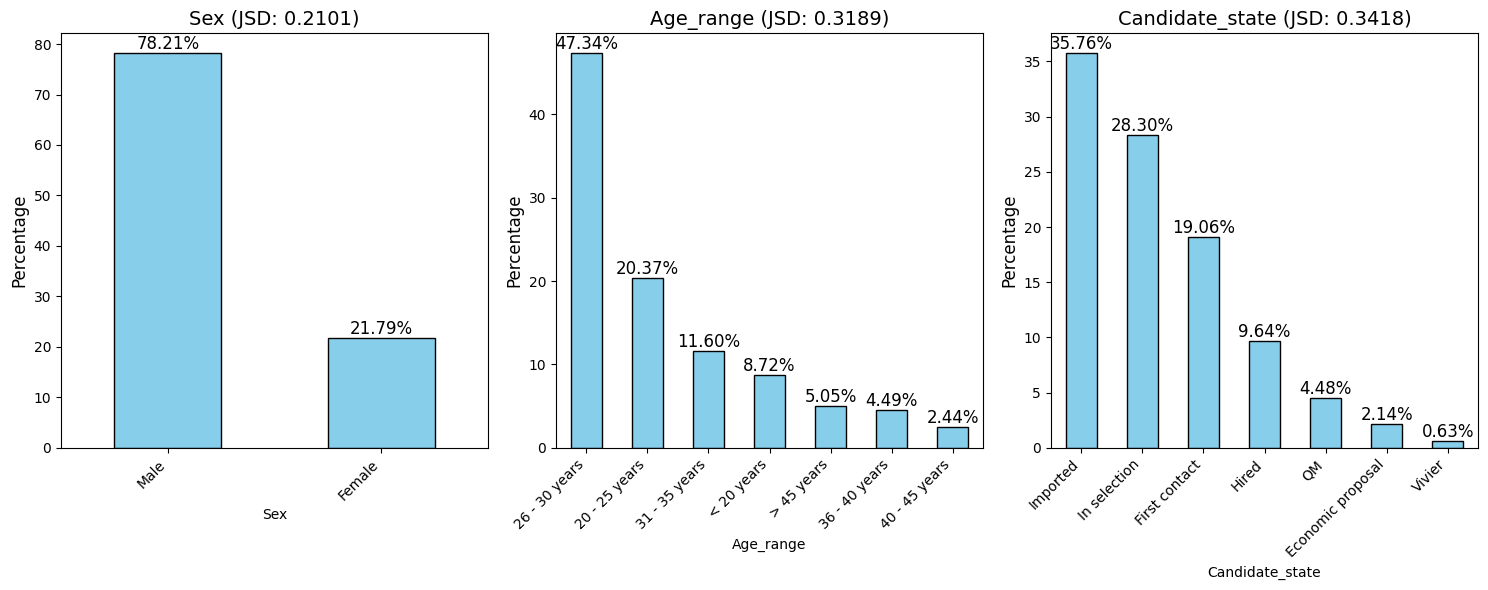

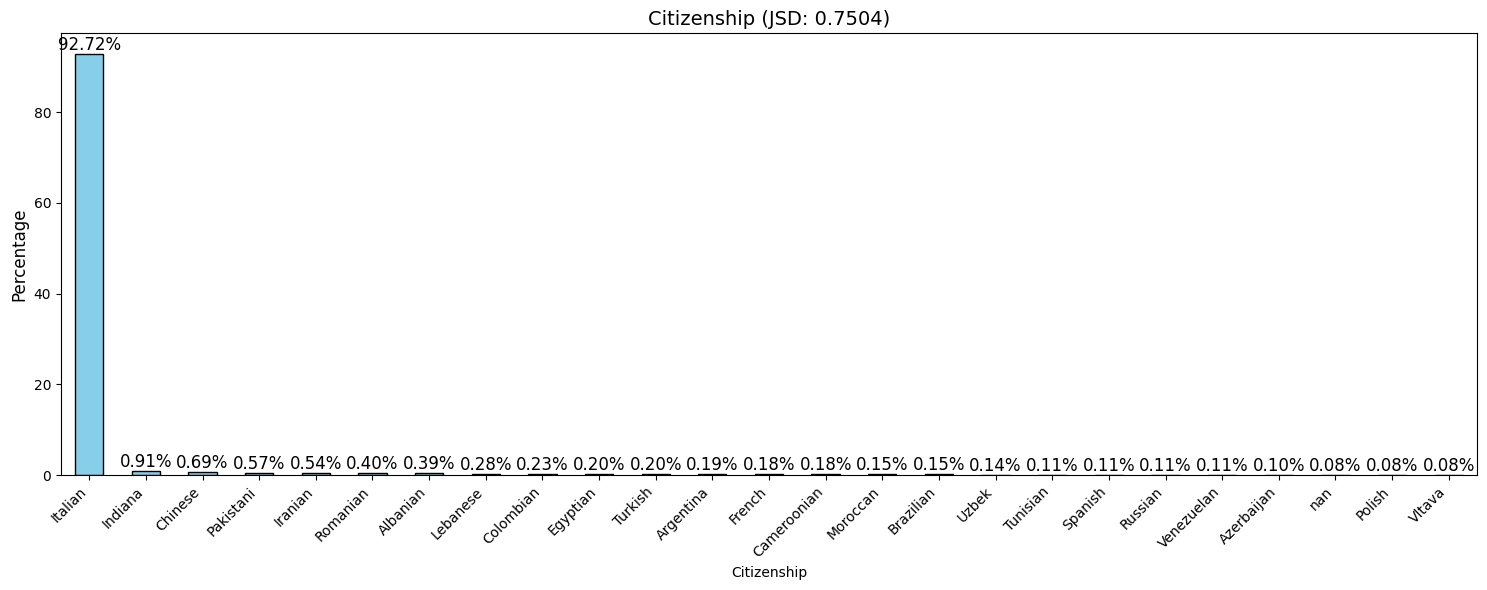

In [ ]:
# Showing JSD distribution for some columns of the dataset
columns_to_evaluate = ['Sex', 'Age_range','Candidate_state']
evaluate_and_plot_columns(data, columns_to_evaluate)

columns_to_evaluate = ['Citizenship']
evaluate_and_plot_columns(data, columns_to_evaluate, c=15)

## Fit Tabula model on the dataset

In [ ]:
model_main = Tabula(llm='distilgpt2', experiment_dir = "training", batch_size=8, epochs=5)

In [ ]:
model_main.fit(data)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
500,1.783300
1000,0.969000
1500,0.842300
2000,0.789300
2500,0.756800
3000,0.726800
3500,0.708500
4000,0.702500
4500,0.686600
5000,0.684100


In [ ]:
#Sampling the synthetic data
synthetic_data_main = model_main.sample(n_samples=5000, max_length=1024, k=100)

  2%|▏         | 100/5000 [00:15<12:41,  6.44it/s]

already_generated:: 100


  4%|▍         | 200/5000 [00:30<12:05,  6.62it/s]

already_generated:: 200


  6%|▌         | 300/5000 [00:44<11:26,  6.85it/s]

already_generated:: 300


  8%|▊         | 400/5000 [01:05<13:11,  5.81it/s]

already_generated:: 400


 10%|█         | 500/5000 [01:22<12:57,  5.79it/s]

already_generated:: 500


 12%|█▏        | 600/5000 [01:37<12:02,  6.09it/s]

already_generated:: 600


 14%|█▍        | 700/5000 [01:47<10:09,  7.05it/s]

already_generated:: 700


 16%|█▌        | 800/5000 [02:00<09:45,  7.17it/s]

already_generated:: 800


 18%|█▊        | 900/5000 [02:18<10:17,  6.63it/s]

already_generated:: 900


 20%|██        | 1000/5000 [02:31<09:39,  6.91it/s]

already_generated:: 1000


 22%|██▏       | 1100/5000 [02:51<10:34,  6.14it/s]

already_generated:: 1100


 24%|██▍       | 1200/5000 [03:11<11:02,  5.73it/s]

already_generated:: 1200


 26%|██▌       | 1300/5000 [03:25<10:00,  6.16it/s]

already_generated:: 1300


 28%|██▊       | 1400/5000 [03:36<08:45,  6.85it/s]

already_generated:: 1400


 30%|███       | 1500/5000 [03:52<08:50,  6.60it/s]

already_generated:: 1500


 32%|███▏      | 1600/5000 [04:02<07:41,  7.37it/s]

already_generated:: 1600


 34%|███▍      | 1700/5000 [04:14<07:08,  7.70it/s]

already_generated:: 1700


 36%|███▌      | 1800/5000 [04:32<07:42,  6.91it/s]

already_generated:: 1800


 38%|███▊      | 1900/5000 [04:46<07:27,  6.93it/s]

already_generated:: 1900


 40%|████      | 2000/5000 [04:54<06:18,  7.93it/s]

already_generated:: 2000


 42%|████▏     | 2100/5000 [05:02<05:25,  8.90it/s]

already_generated:: 2100


 44%|████▍     | 2200/5000 [05:22<06:27,  7.22it/s]

already_generated:: 2200


 46%|████▌     | 2300/5000 [05:32<05:43,  7.86it/s]

already_generated:: 2300


 48%|████▊     | 2400/5000 [05:49<05:59,  7.22it/s]

already_generated:: 2400


 50%|█████     | 2500/5000 [06:09<06:30,  6.40it/s]

already_generated:: 2500


 52%|█████▏    | 2600/5000 [06:26<06:24,  6.24it/s]

already_generated:: 2600


 54%|█████▍    | 2700/5000 [06:42<06:10,  6.20it/s]

already_generated:: 2700


 56%|█████▌    | 2800/5000 [07:04<06:33,  5.60it/s]

already_generated:: 2800


 58%|█████▊    | 2900/5000 [07:18<05:51,  5.97it/s]

already_generated:: 2900


 60%|██████    | 3000/5000 [07:33<05:23,  6.17it/s]

already_generated:: 3000


 62%|██████▏   | 3100/5000 [07:51<05:18,  5.97it/s]

already_generated:: 3100


 64%|██████▍   | 3200/5000 [08:00<04:21,  6.87it/s]

already_generated:: 3200


 66%|██████▌   | 3300/5000 [08:12<03:51,  7.35it/s]

already_generated:: 3300


 68%|██████▊   | 3400/5000 [08:22<03:20,  7.98it/s]

already_generated:: 3400


 70%|███████   | 3500/5000 [08:43<03:48,  6.57it/s]

already_generated:: 3500


 72%|███████▏  | 3600/5000 [09:00<03:37,  6.43it/s]

already_generated:: 3600


 74%|███████▍  | 3700/5000 [09:16<03:26,  6.30it/s]

already_generated:: 3700


 76%|███████▌  | 3800/5000 [09:36<03:24,  5.87it/s]

already_generated:: 3800


 78%|███████▊  | 3900/5000 [09:52<03:04,  5.95it/s]

already_generated:: 3900


 80%|████████  | 4000/5000 [10:08<02:46,  6.00it/s]

already_generated:: 4000


 82%|████████▏ | 4100/5000 [10:29<02:39,  5.64it/s]

already_generated:: 4100


 84%|████████▍ | 4200/5000 [10:49<02:27,  5.44it/s]

already_generated:: 4200


 86%|████████▌ | 4300/5000 [11:11<02:16,  5.13it/s]

already_generated:: 4300


 88%|████████▊ | 4400/5000 [11:23<01:44,  5.76it/s]

already_generated:: 4400


 90%|█████████ | 4500/5000 [11:40<01:26,  5.78it/s]

already_generated:: 4500


 92%|█████████▏| 4600/5000 [11:57<01:08,  5.87it/s]

already_generated:: 4600


 94%|█████████▍| 4700/5000 [12:10<00:47,  6.28it/s]

already_generated:: 4700


 96%|█████████▌| 4800/5000 [12:28<00:32,  6.07it/s]

already_generated:: 4800


 98%|█████████▊| 4900/5000 [12:44<00:16,  6.04it/s]

already_generated:: 4900


100%|██████████| 5000/5000 [12:57<00:00,  6.43it/s]

already_generated:: 5000


In [ ]:
synthetic_data_main.to_excel('/content/drive/MyDrive/AI_Industry/Output/generated_main_5000.xlsx', index=False)
synthetic_data_main.to_pickle('/content/drive/MyDrive/AI_Industry/Output/generated_main_5000.pkl')

In [ ]:
synthetic_data_main

,code,ID,Candidate_state,Age_range,Citizenship,Residence,Sex,Protected_Category,TAG,Study_area,...,Akkodis_headquarters,Current_Ral,Expected_Ral,Technical_Skills,Standing_Position,Comunication,Maturity,Dynamism,Mobility,English
0,8850,65155,Imported,26 - 30 years,Italian,TURIN » Turin ~ Piedmont,Male,nan,nan,computer engineering,...,nan,None,nan,nan,nan,nan,nan,nan,nan,nan
1,8095,526,In selection,26 - 30 years,Italian,MONTE ARGENTINO » Benevento ~ Campania,Male,nan,ENG. AEROSPACE,electronic Engineering,...,nan,nan,nan,2,3.0,3.0,3.0,3.0,3.0,3.0
2,10398,58298,Imported,20 - 25 years,Italian,TURIN » Turin ~ Piedmont,Male,None,nan,Information Engineering,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,4386,60229,In selection,26 - 30 years,Italian,SAN GIOVANNI » Catania ~ Sicily,Male,None,C; C++; EMBEDDED; SW DEVELOPER; V&V; SW,electronic Engineering,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4,13861,48152,Imported,26 - 30 years,Italian,GALLO » Lecce ~ Puglia,Male,nan,nan,Management Engineering,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2995,1142,15448,In selection,20 - 25 years,Italian,TURIN » Turin ~ Piedmont,Male,nan,nan,Mechanical engineering,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2996,11409,70160,In selection,26 - 30 years,Italian,VENAFRO » Bologna ~ Emilia Romagna,Male,nan,-,Mechanical engineering,...,nan,nan,nan,2,1.0,2.0,2.0,2.0,3.0,None
2997,6361,53732,Imported,26 - 30 years,Italian,TURIN » Turin ~ Piedmont,Male,nan,None,Mechanical engineering,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2998,None,2064,In selection,< 20 years,Italian,ROME » Rome ~ Lazio,Male,nan,None,Informatics,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan


## Statistics on the generated data

                     Column  KL Divergence
29                 Mobility       0.007864
25        Standing_Position       0.010475
26             Comunication       0.010527
28                 Dynamism       0.012573
4        Protected_Category       0.012714
3                       Sex       0.015271
24         Technical_Skills       0.016953
9         Year_of_insertion       0.044991
27                 Maturity       0.052904
15                  Overall       0.060036
6               Study_Title       0.061172
10      Year_of_Recruitment       0.065858
16       Years_Experience_1       0.067963
14           event_feedback       0.069951
13          event_type__val       0.085441
12        Job_Family_Hiring       0.089079
17              Minimum_Ral       0.089194
0           Candidate_state       0.097223
11  Assumption_Headquarters       0.109914
19              Study_Level       0.110483
1                 Age_range       0.115405
21     Akkodis_headquarters       0.123803
8          

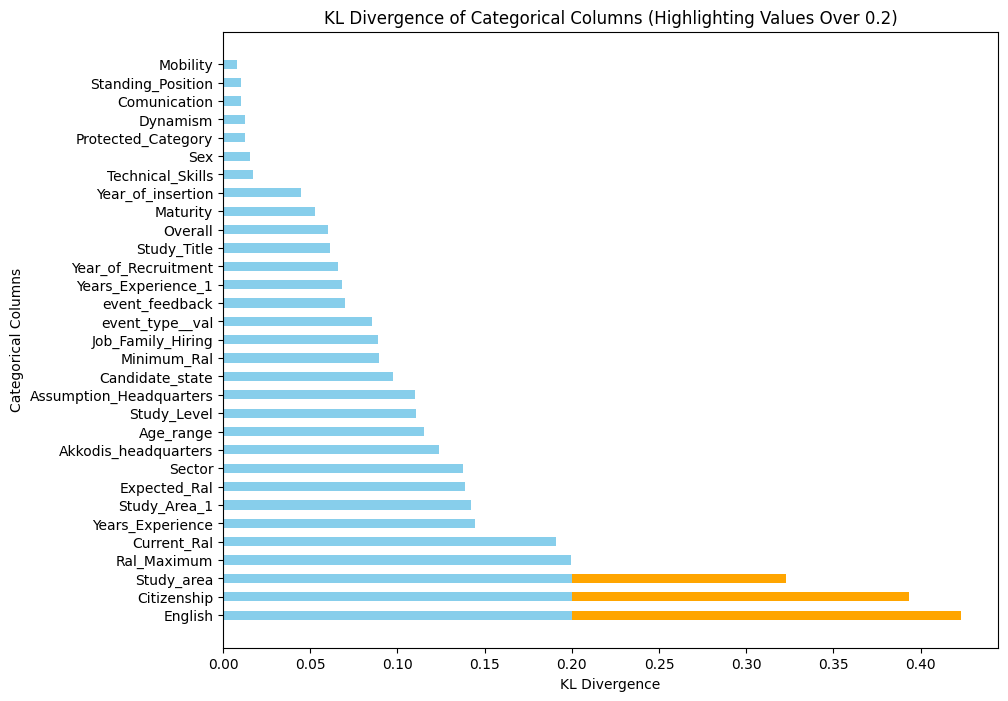

In [ ]:
original_data = data
synthetic_data = synthetic_data_main

results = []
for col in categorical_columns:
    kl_div = calculate_kl_divergence(original_data[col], synthetic_data[col])
    results.append({"Column": col, "KL Divergence": kl_div})

show_kl_result(results)

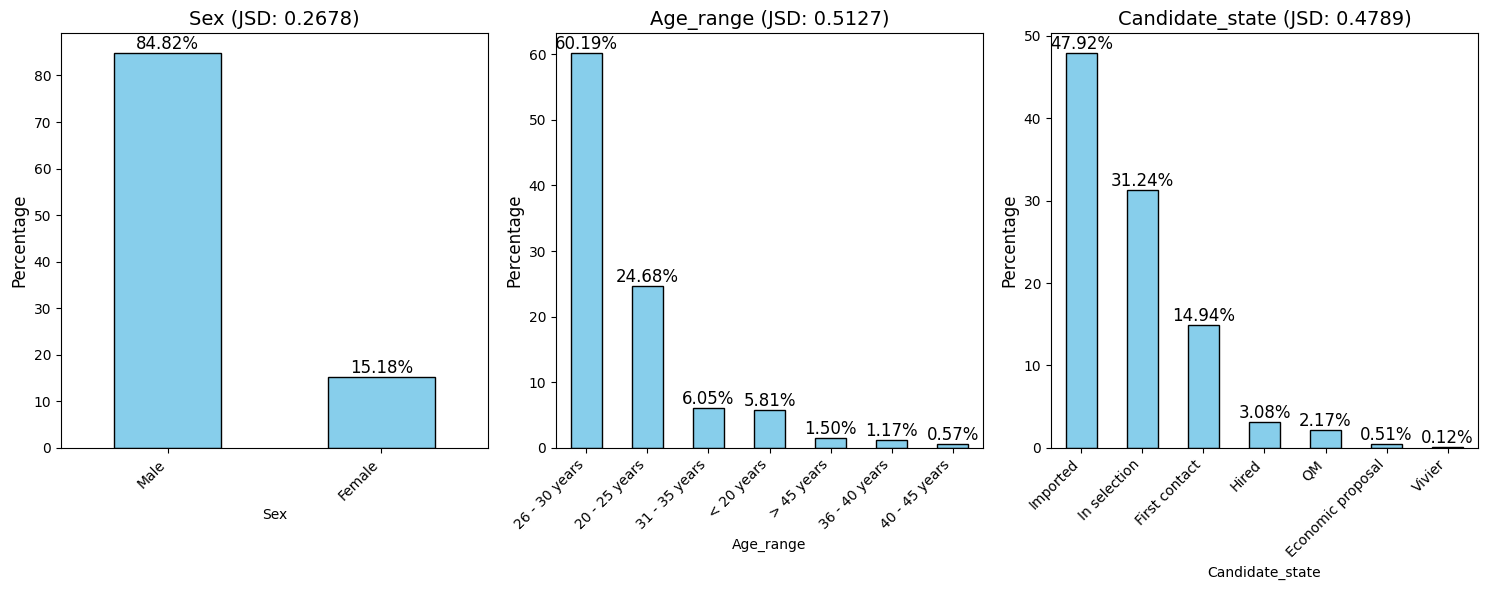

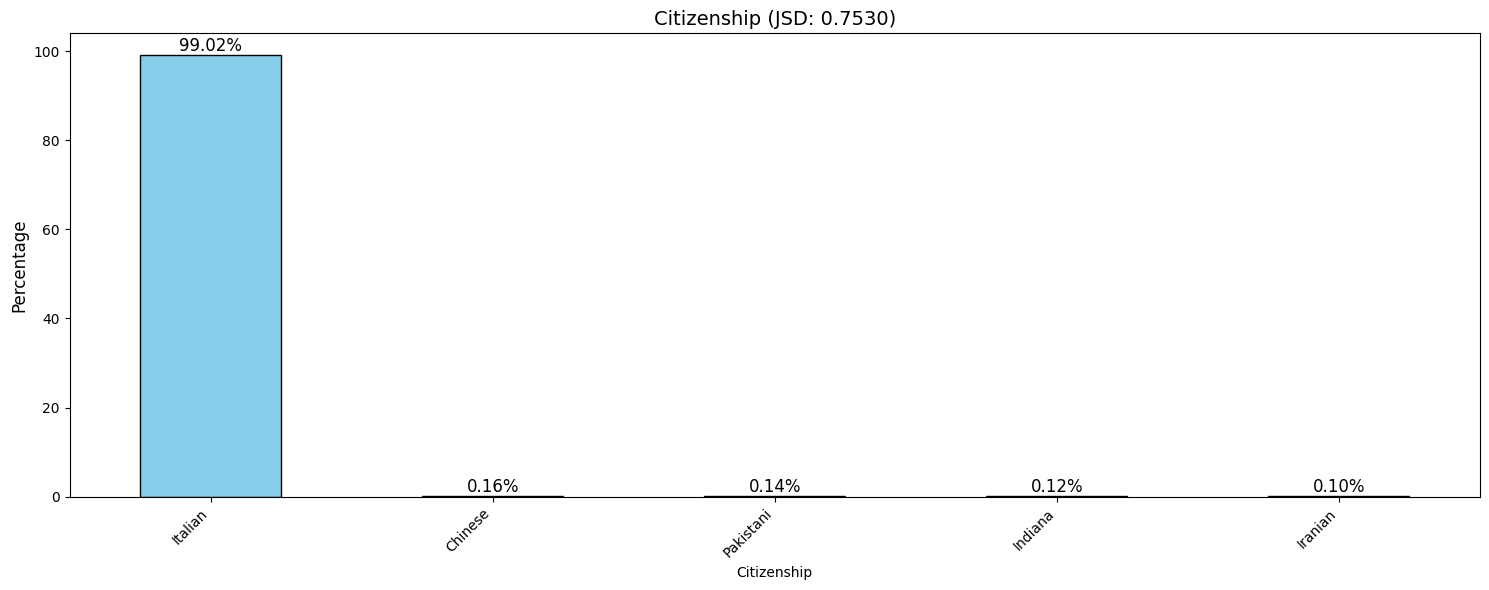

In [ ]:
columns_to_evaluate = ['Sex', 'Age_range','Candidate_state']
evaluate_and_plot_columns(synthetic_data_main, columns_to_evaluate)

columns_to_evaluate = ['Citizenship']
evaluate_and_plot_columns(synthetic_data_main, columns_to_evaluate, c=15)

## Data - Equally sampled with respect to sex
Gender bias Mitigation Strategy:
To reduce bias, we created a balanced dataset with equal representation of gender. By sampling 9,156 records with a 50-50 split between male and female, we aim to provide the model with fairer input data, promoting more equitable learning outcomes.


In [ ]:
male_df = data[data['Sex'] == 'Male']
female_df = data[data['Sex'] == 'Female']

min_size = min(len(male_df), len(female_df))

male_sample = male_df.sample(n=min_size, random_state=42)
female_sample = female_df.sample(n=min_size, random_state=42)

data_equal = pd.concat([male_sample, female_sample])
data_equal

,code,ID,Candidate_state,Age_range,Citizenship,Residence,Sex,Protected_Category,TAG,Study_area,...,Akkodis_headquarters,Current_Ral,Expected_Ral,Technical_Skills,Standing_Position,Comunication,Maturity,Dynamism,Mobility,English
19142,19142,35097,Imported,20 - 25 years,Italian,RIVOLI » Turin ~ Piedmont,Male,nan,nan,computer engineering,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
11600,11600,15526,In selection,20 - 25 years,Italian,ROME » Rome ~ Lazio,Male,nan,"SOLIDWORKS, CREO, CATIA, AUTOCAD, CAD, CAD FEM...",Mechanical engineering,...,nan,Not available,Not available,2,2.0,2.0,2.0,2.0,2.0,3.0
2886,2886,46769,In selection,> 45 years,Italian,MILAN » Milan ~ Lombardy,Male,nan,MACHINERY,Surveyor,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
13050,13050,79833,In selection,26 - 30 years,Colombian,NAPLES » Naples ~ Campania,Male,nan,nan,Automation/Mechatronics Engineering,...,nan,nan,nan,2,2.0,2.0,3.0,3.0,2.0,3.0
13799,13799,66990,Economic proposal,> 45 years,Italian,REPUBLIC OF POLAND » (STATE) ~ (OVERSEAS),Male,nan,E&I SUPERINTENDENT OFF-SHORE; FPSO,Electrical Engineering,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20696,20696,53407,In selection,< 20 years,Italian,BOLOGNA » Bologna ~ Emilia Romagna,Female,nan,X,computer engineering,...,nan,Not available,Not available,2,3.0,3.0,2.0,2.0,1.0,3.0
2297,2297,45065,Hired,26 - 30 years,Italian,TURIN » Turin ~ Piedmont,Female,nan,"DATA ANALYSIS, SOLIDWORKS, EXCEL, OFFICE, NX, ...",Automotive Engineering,...,Turin,nan,nan,2,2.0,3.0,2.0,3.0,3.0,3.0
14222,14222,28968,Imported,26 - 30 years,Italian,BARLETTA » Barletta-Andria-Trani ~ Puglia,Female,nan,nan,Mechanical engineering,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
17202,17202,61456,In selection,26 - 30 years,Italian,CARNATE » Monza-Brianza ~ Lombardy,Female,nan,nan,Other scientific subjects,...,nan,nan,nan,3,3.0,3.0,3.0,3.0,3.0,3.0


In [ ]:
# data_equal.to_excel('/content/drive/MyDrive/AI_Industry/Output/dataset_Equal1.xlsx', index=False)

                  Column  KL Divergence
20              Maturity       0.000686
21              Dynamism       0.000780
15               English       0.000783
7      Year_of_insertion       0.000810
8    Year_of_Recruitment       0.000864
16              Mobility       0.000962
18     Standing_Position       0.001298
19          Comunication       0.001338
17      Technical_Skills       0.001348
11        event_feedback       0.001371
4            Study_Title       0.001407
12               Overall       0.001565
9      Job_Family_Hiring       0.002044
10       event_type__val       0.002567
14           Current_Ral       0.002746
6       Years_Experience       0.003024
2              Age_range       0.003030
1        Candidate_state       0.004498
13  Akkodis_headquarters       0.006816
5                 Sector       0.009026
3             Study_area       0.032370
0                    Sex       0.168968


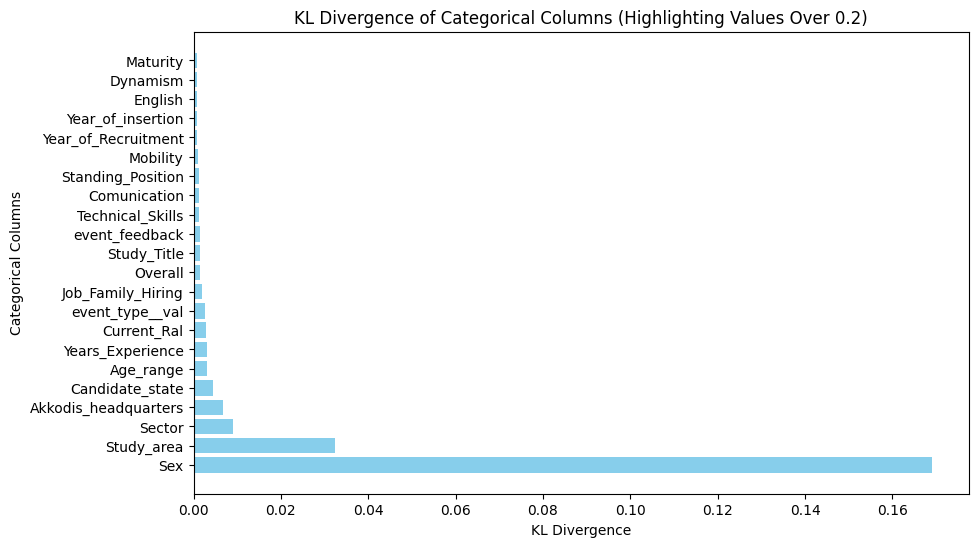

In [ ]:
# Here we examine the KL divergence between the original dataset and the equally sampled data 
# to ensure the sampled data maintains a similar distribution. 
# Notably, the "Sex" field shows a relatively high divergence, while other fields 
# closely match the distribution of the original dataset.

original_data = data
synthetic_data = data_equal

results = []
for col in categorical_columns:
    kl_div = calculate_kl_divergence(original_data[col], synthetic_data[col])
    results.append({"Column": col, "KL Divergence": kl_div})

show_kl_result(results)

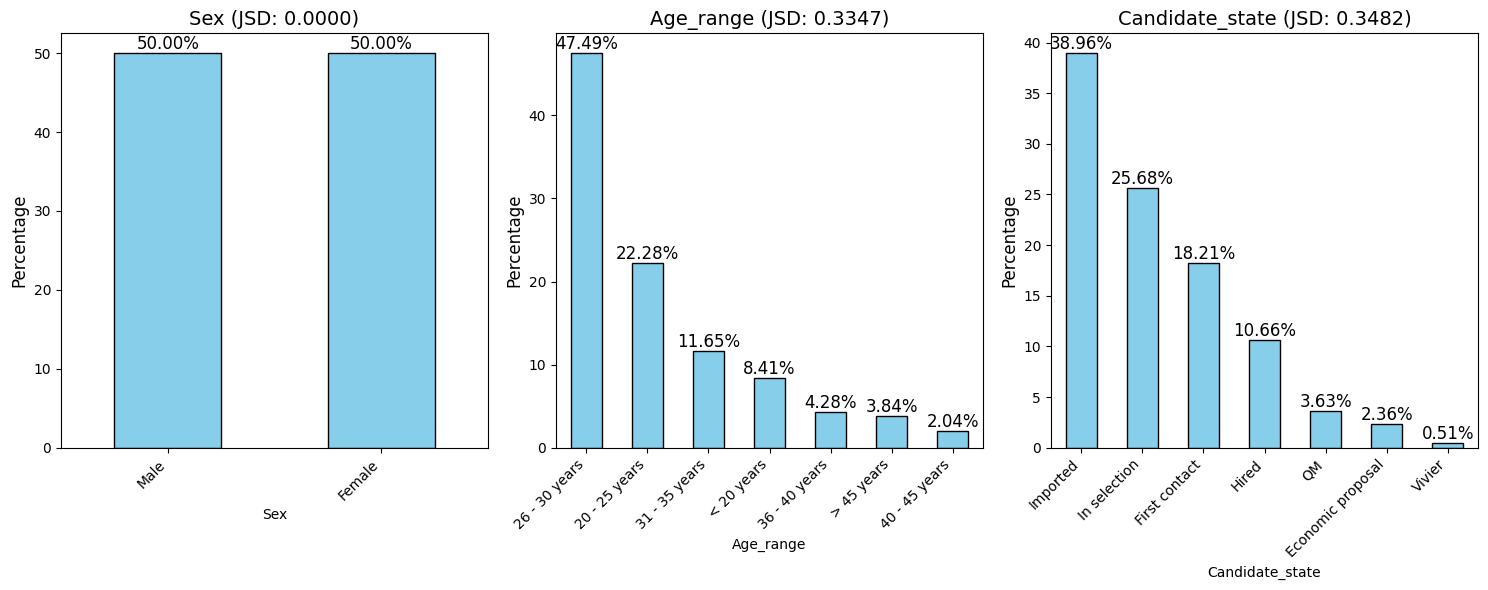

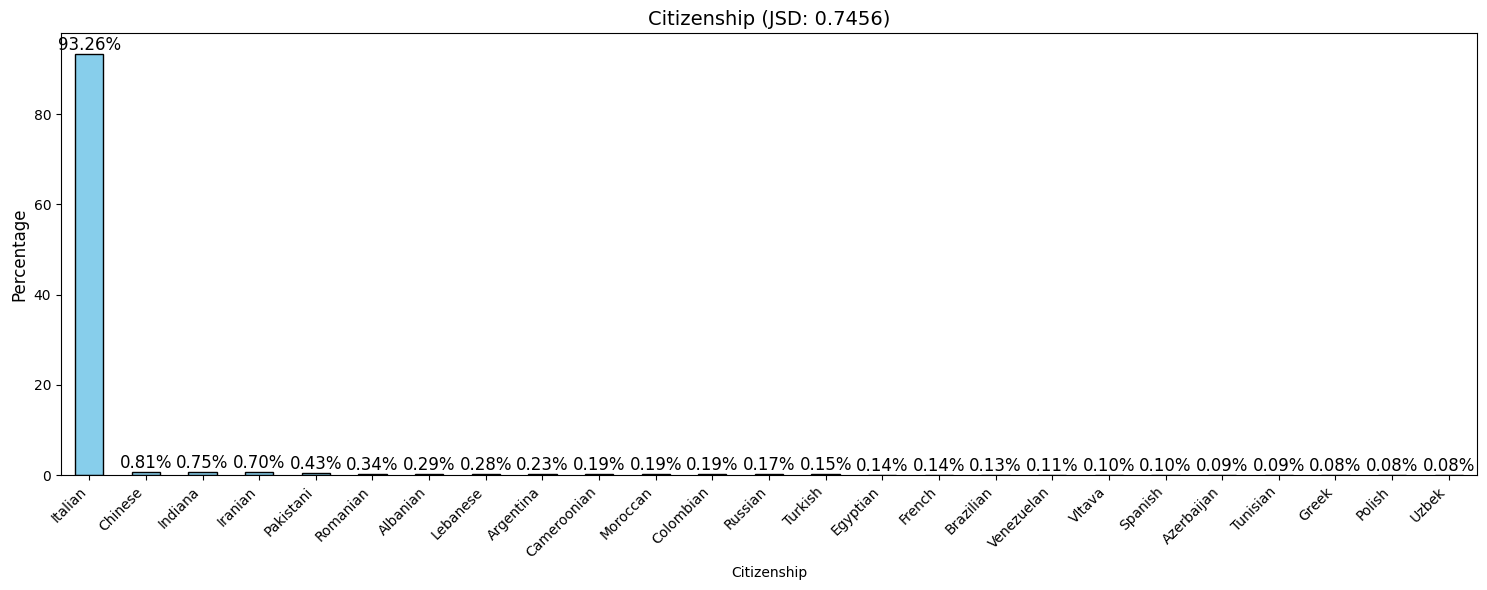

In [ ]:
columns_to_evaluate = ['Sex', 'Age_range','Candidate_state']
evaluate_and_plot_columns(data_equal, columns_to_evaluate)

columns_to_evaluate = ['Citizenship']
evaluate_and_plot_columns(data_equal, columns_to_evaluate, c=15)

## Fit on the sampled data

In [ ]:
model_equal = Tabula(llm='distilgpt2', experiment_dir = "training", batch_size=8, epochs=10)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [ ]:
model_equal.fit(data_equal)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss
500,1.783600
1000,0.959600
1500,0.836000
2000,0.774900
2500,0.732700
3000,0.713000
3500,0.694300
4000,0.674500
4500,0.667800
5000,0.648400


In [ ]:
synthetic_data3 = model_equal.sample(n_samples=5000, max_length=1024, k=100)

In [ ]:
synthetic_data3.to_excel('/content/drive/MyDrive/AI_Industry/Output/generated_Equal1_5000.xlsx', index=False)

In [ ]:
synthetic_data3

,code,ID,Candidate_state,Age_range,Citizenship,Residence,Sex,Protected_Category,TAG,Study_area,...,Akkodis_headquarters,Current_Ral,Expected_Ral,Technical_Skills,Standing_Position,Comunication,Maturity,Dynamism,Mobility,English
0,15227,51684,Imported,26 - 30 years,Italian,CHIERI » Turin ~ Piedmont,Male,nan,nan,Energy and Nuclear Engineering,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
1,9769,64795,In selection,26 - 30 years,Italian,TURIN » Turin ~ Piedmont,Female,nan,-,electronic Engineering,...,nan,nan,nan,3,3.0,3.0,2.0,3.0,3.0,None
2,14893,47685,In selection,26 - 30 years,Italian,BRONA » Turin ~ Piedmont,Female,nan,C; C++; JAVA; MATLAB/SIMULINK; TASHiring nan,computer engineering,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
3,16564,55622,In selection,31 - 35 years,Italian,PADUA » Padua ~ Veneto,Male,nan,CENELEC,Other scientific subjects,...,nan,nan,nan,2,3.0,3.0,2.0,2.0,3.0,None
4,20305,10863,First contact,20 - 25 years,Italian,TURIN » Turin ~ Piedmont,Female,nan,None,Mechanical engineering,...,nan,Not available,Not available,nan,nan,nan,nan,nan,nan,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,2129,80588,In selection,26 - 30 years,Italian,BITONTO » Bari ~ Puglia,Female,nan,nan,Biomedical Engineering,...,nan,nan,nan,2,2.0,2.0,3.0,2.0,2.0,None
4996,10653,66964,Imported,26 - 30 years,Italian,TURIN » Turin ~ Piedmont,Female,nan,nan,Biomedical Engineering,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
4997,14057,9891,In selection,26 - 30 years,Italian,TURIN » Turin ~ Piedmont,Female,nan,AEROSPACE ENGINEERING; ANSYS; SYSTEM ENGINEER,Biomedical Engineering,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,None
4998,20607,58323,In selection,20 - 25 years,Italian,TURIN » Turin ~ Piedmont,Female,nan,AUTOMOTIVE,Mechanical engineering,...,nan,nan,nan,2,2.0,3.0,2.0,3.0,2.0,None


In [ ]:
# torch.save(model2.model.state_dict(), "/content/drive/MyDrive/AI_Industry/model/model_equal_1.pt")

In [ ]:
# Save DataFrame as a CSV file
# synthetic_data3.to_csv("/content/drive/MyDrive/AI_Industry/Output/filename.csv", index=False)


## Statistics on Equally generated data

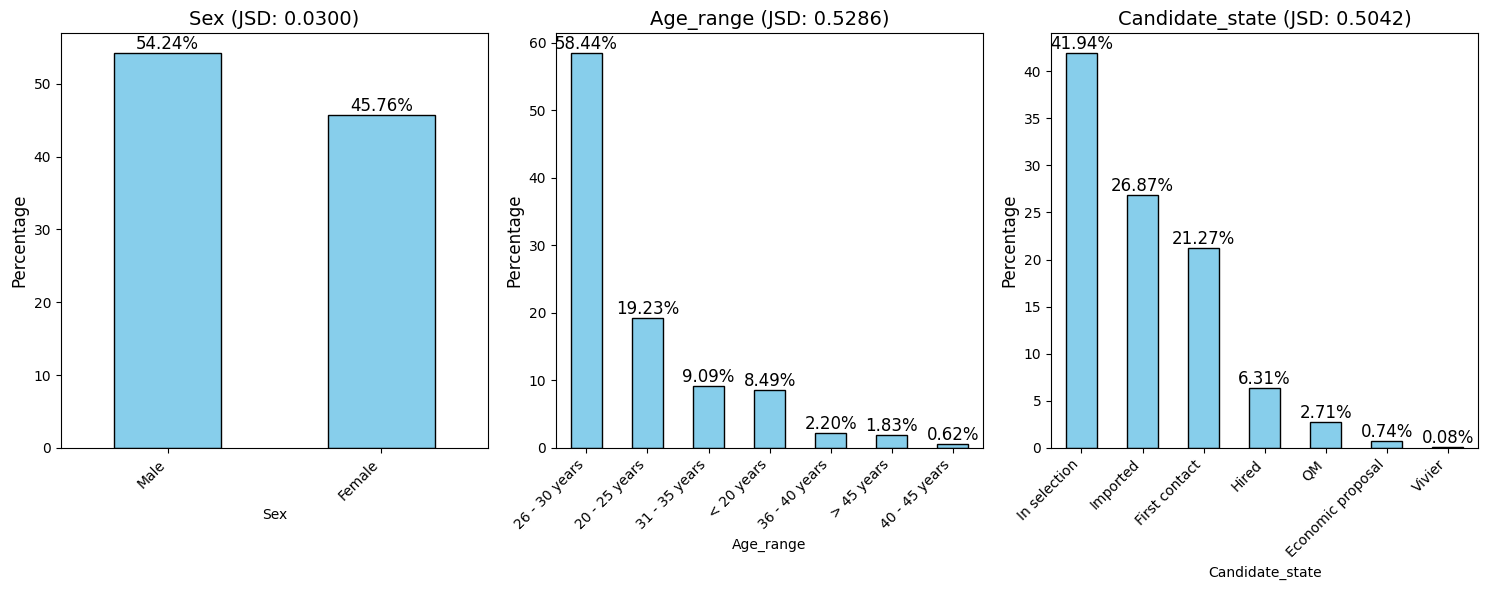

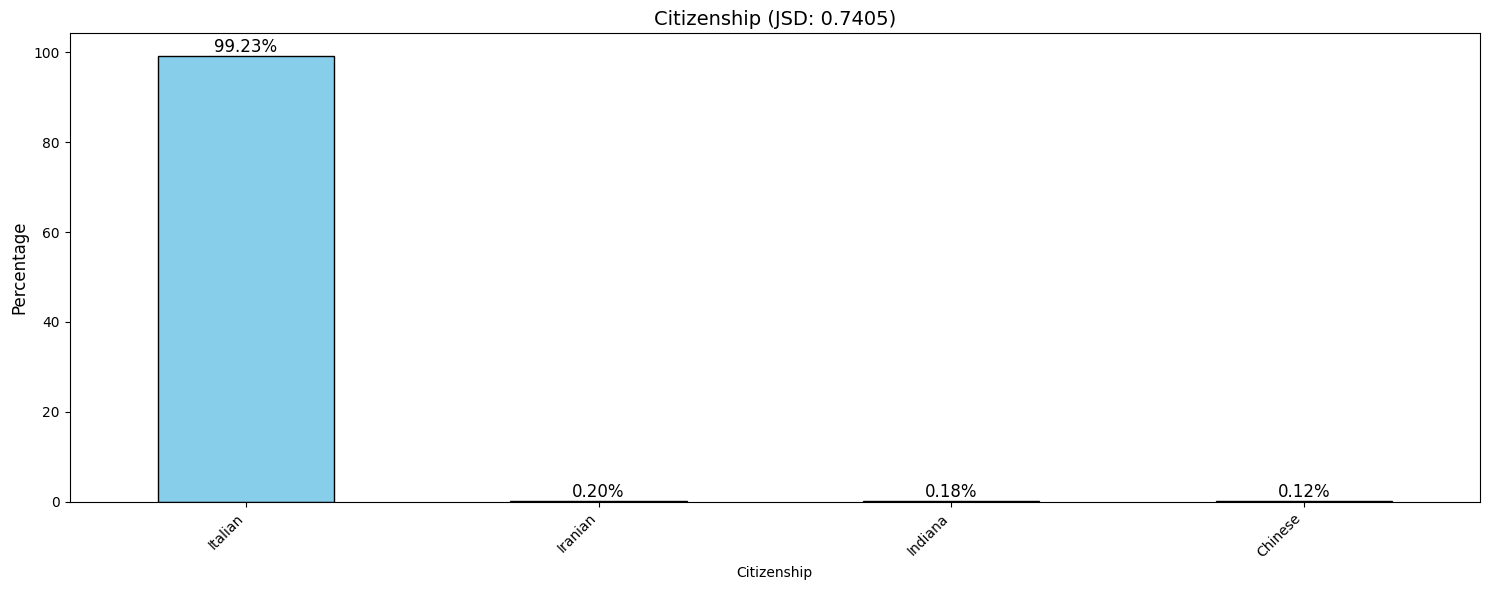

In [ ]:
columns_to_evaluate = ['Sex', 'Age_range','Candidate_state']
evaluate_and_plot_columns(synthetic_data3, columns_to_evaluate)

columns_to_evaluate = ['Citizenship']
evaluate_and_plot_columns(synthetic_data3, columns_to_evaluate, c=15)

KL Divergence with the sampled dataset with equal genders

                     Column  KL Divergence
0                       Sex       0.003603
22       Protected_Category       0.009679
16                 Mobility       0.013481
21                 Dynamism       0.014184
20                 Maturity       0.014916
19             Comunication       0.015393
17         Technical_Skills       0.015406
18        Standing_Position       0.015869
12                  Overall       0.026556
8       Year_of_Recruitment       0.035871
11           event_feedback       0.040940
2                 Age_range       0.043668
6          Years_Experience       0.047187
10          event_type__val       0.048286
13     Akkodis_headquarters       0.051523
27  Assumption_Headquarters       0.056769
7         Year_of_insertion       0.056911
9         Job_Family_Hiring       0.058635
26              Study_Level       0.068669
4               Study_Title       0.073116
24       Years_Experience_1       0.075791
14              Current_Ral       0.086909
25         

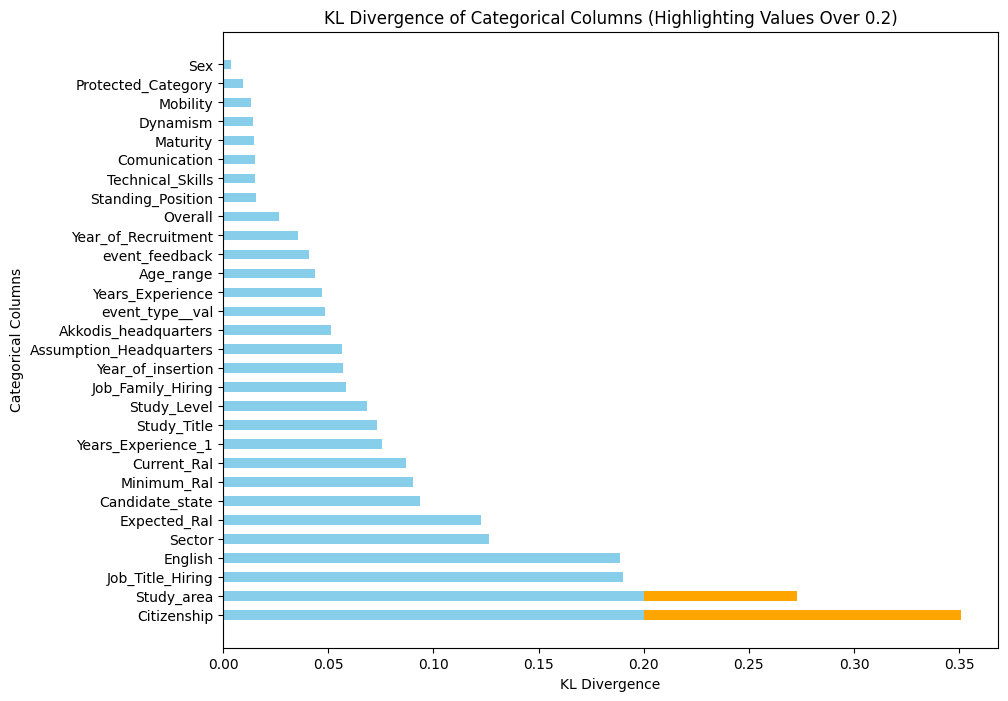

In [ ]:
original_data = data_equal
synthetic_data = synthetic_data3

results = []
for col in categorical_columns:
    kl_div = calculate_kl_divergence(original_data[col], synthetic_data[col])
    results.append({"Column": col, "KL Divergence": kl_div})

show_kl_result(results)

KL Divergence with the main dataset

                     Column  KL Divergence
22       Protected_Category       0.009314
20                 Maturity       0.010137
18        Standing_Position       0.010423
19             Comunication       0.010507
16                 Mobility       0.011246
21                 Dynamism       0.011426
17         Technical_Skills       0.013518
12                  Overall       0.022470
8       Year_of_Recruitment       0.028013
10          event_type__val       0.033449
9         Job_Family_Hiring       0.038265
13     Akkodis_headquarters       0.051612
2                 Age_range       0.059030
11           event_feedback       0.060848
7         Year_of_insertion       0.062980
27  Assumption_Headquarters       0.063969
1           Candidate_state       0.068827
26              Study_Level       0.072101
6          Years_Experience       0.074364
4               Study_Title       0.082435
25              Minimum_Ral       0.082926
24       Years_Experience_1       0.083790
14         

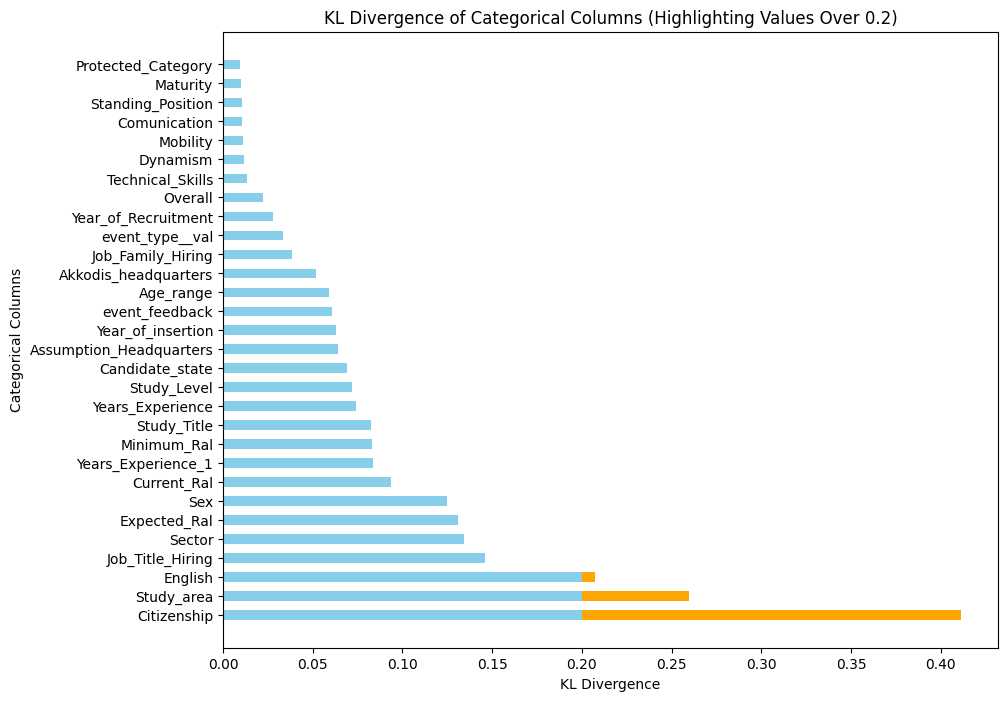

In [ ]:
original_data = data
synthetic_data = synthetic_data3

results = []
for col in categorical_columns:
    kl_div = calculate_kl_divergence(original_data[col], synthetic_data[col])
    results.append({"Column": col, "KL Divergence": kl_div})

show_kl_result(results)